In [24]:
#B2_OL
# """
# Compute O/L offset for envisat from binned data
# - area-weighted average of overlapping cells
# - monthly climatology of all months
#
# - uses the one file with all gridded data instead of individual files
#
# Last modified: 30 Mar 2021
# """
#------------------------------------------------------------------
"""
# TEMPORAL VARIABILITY
- compute monthly spatial mean/median/stdev of the the bias
- make time series of the monthly spatial means + stdev
- is there a seasonal signal?

# SEASONAL VARIABILITY/CLIMATOLOGY
- average spatial mean by month
- look at StDev by month
- similar to Tiago's method

# SAPTIAL VARIABILITY
- divide into 30 -60 deg long regions
- look at time series of the monthly spatial averages for that region
- check how stdev compares with the climatology
"""
#------------------------------------------------------------------

## Import modules
import numpy as np
from numpy import ma

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import cm

import xarray as xr
import pandas as pd

from scipy.stats import kurtosis, skew

import sys


#-------------------------------------------------------------------------------

def skew_kurt_hist(var, month):
    skew0 = kurtosis(var.flatten(), nan_policy='omit')
    kurt0 = skew(var.flatten(), nan_policy='omit')
    print('Kurtosis: ', skew0)
    print('Skewnesss: ', kurt0)

    fig, ax = plt.subplots()
    ax.hist(var.flatten() * 1e2, bins=17,
            label='n_thresh=%s' % str(n_thresh))
    ax.annotate('skew = %.4f' % skew0,
                xy=(.15, .8),
                xycoords='figure fraction')
    ax.annotate('kurt = %.4f' % kurt0,
                xy=(.15, .75),
                xycoords='figure fraction')

    ax.legend(loc=2)
    ax.set_title("%s O-L offset (cm) %s" % (satellite, month), loc='left')
    plt.tight_layout()


#-------------------------------------------------------------------
# Define directories
#-------------------------------------------------------------------

voldir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/'
ncdir = voldir + 'altimetry_cpom/1_raw_nc/'
bindir = voldir + 'altimetry_cpom/2_grid_offset/'

scriptdir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_scripts/'
auxscriptdir = scriptdir + 'aux_func/'

sys.path.append(auxscriptdir)
import aux_func as ft
import aux_stereoplot as st

#- - - - - - - - - - - - - -

#-------------------------------------------------------
# bin edges
edges_lon = np.linspace(-180, 180, num=361, endpoint=True)
edges_lat = np.linspace(-82, -50, num=65, endpoint=True)
eglat, eglon = np.meshgrid(edges_lat, edges_lon)

total_area = ft.grid_area(eglon, eglat)
#-------------------------------------------------------

# # # # # # # # # # # #
statistic = 'mean'
satellite = 'cs2'
n_thresh = 30
# # # # # # # # # # # #

print("- - - - - - - - - - - - - - ")
print("> > bin statistic: %s" % statistic)
print("> > satellite: %s" % satellite)
print("> > bin threshold: %s" % str(n_thresh))
print("- - - - - - - - - - - - - - \n")

#------------------------------------------------------------------
filename = 'b01_bin_ssha_OL_' + satellite + '_' + str(statistic) + '.nc'

with xr.open_dataset(bindir + filename) as bin0:
    print(bin0.keys)

#------------------------------------------------------------------
# OFFSET computation
#------------------------------------------------------------------
# discard bins with fewer points than a certain threshold
bin0.ssha_o.values[bin0.npts_o < n_thresh] = np.nan
bin0.ssha_l.values[bin0.npts_l < n_thresh] = np.nan

# subtract leads from ocean
offset = (bin0.ssha_o - bin0.ssha_l).transpose('longitude', 'latitude', 'time')
offset.values[bin0.land_mask == 1] = np.nan
offset = offset.to_dataset(name='ol_dif')

# create weights based on the surface area of each bin
ones = np.ones(offset.ol_dif.shape)
ones[np.isnan(offset.ol_dif.values)] = 0
arr_area = total_area[:, :, np.newaxis] * ones

# normalize weights
sum_area = arr_area.sum(axis=(0, 1))
norm_area = arr_area / sum_area

#offset['weights'] = (('longitude', 'latitude', 'time'), norm_area) - Oana original code
offset['weights'] = (('longitude', 'latitude', 'time'), np.nan_to_num(norm_area))

#------------------------------------------------------------------
#- - - - - - - - - - - - - -
#- - - - - - - - - - - - - -
# > > a. area weighted mean and StDev for every month
# results are the same as my implementation of the weighted avg
#- - - - - - - - - - - - - -
#- - - - - - - - - - - - - -
weighted_obj = offset.ol_dif.weighted(offset.weights)
monthly_off_weighted = weighted_obj.mean(('longitude', 'latitude'))

# a. climatology of monthly area-weighted mean offset
monthly_off_clim = monthly_off_weighted.groupby('time.month').mean('time')

#- - - - - - - - - - - - - -

# standard deviation - weighted
monthly_res_sq = (offset.ol_dif - monthly_off_weighted) ** 2
weighted_obj_res_sq = monthly_res_sq.weighted(offset.weights)
monthly_variance_weighted = weighted_obj_res_sq.mean(('longitude', 'latitude'))
monthly_std_weighted = np.sqrt(monthly_variance_weighted)

# standard deviation - not weighted - ALMOST SIMILAR
monthly_variance = monthly_res_sq.mean(('longitude', 'latitude'))
monthly_std = np.sqrt(monthly_variance)

# spread of monthly area-weighted mean for every month
monthly_off_clim_std = monthly_off_weighted.groupby('time.month').std('time')

# error addition (sqrt of sum of square std)
comb_std_sum = (monthly_std ** 2).groupby('time.month').sum()
comb_std_clim = np.sqrt(comb_std_sum)

#- - - - - - - - - - - - - -
#- - - - - - - - - - - - - -
# > > b. for every month, average offset in time in every bin
#- - - - - - - - - - - - - -
#- - - - - - - - - - - - - -
offset_month = offset.ol_dif.groupby('time.month').mean('time')
offset_month_std = offset.ol_dif.groupby('time.month').std('time', ddof=1)

# keep only bins where std <= 0.7 m
offset_month.values[offset_month_std > 0.7] = np.nan
offset_month.values[np.isnan(offset_month_std)] = np.nan

offset_month = offset_month.to_dataset(name='ol_m')

# > > b. area weighted avg for every time-averaged month
# create weights based on the surface area of each bin
ones = np.ones(offset_month.ol_m.shape)
ones[np.isnan(offset_month.ol_m.values)] = 0
arr_area = total_area[:, :, np.newaxis] * ones

offset_month['weights'] = (('longitude', 'latitude', 'month'), arr_area)

# climatology - weights for every calendar month avg (12)
off_obj = offset_month.ol_m.weighted(offset_month.weights)
off_mclim = off_obj.mean(('longitude', 'latitude'))

res = (offset_month.ol_m - off_mclim) ** 2
res_obj = res.weighted(offset_month.weights)
res_var = res_obj.mean(('longitude', 'latitude'))
off_mclim_std = np.sqrt(res_var)

#------------------------------------------------------------------
# stereographical PLOT for individual months
#------------------------------------------------------------------
cbar_range = [-30, 30]
cbar_units = 'cm'
cmap = cm.seismic

k = 1
fig, ax, m = st.spstere_plot(eglon, eglat,
                             offset.ol_dif.isel(time=k) * 100,
                             cbar_range, cmap, cbar_units, None)

#- - - - - - - - - - - - - -
var = offset.ol_dif.values.flatten()
skew_kurt_hist(var, '')

#- - - - - - - - - - - - - -
xtim = monthly_off_weighted.time.values
fig, ax = plt.subplots(figsize=(12, 3))

ax.plot(xtim,
        monthly_off_weighted.values * 1e2,
        c='k', marker='o', markersize=4)
ax.errorbar(xtim,
            monthly_off_weighted.values * 1e2,
            yerr=monthly_std.values * 1e2,
            capsize=3, ecolor='k',
            color='none', lw=1.)
ax.set_xticks(xtim, minor=True)
ax.grid(True, which='major', lw=1., ls='-')
ax.grid(True, which='minor', lw=1., ls=':')
ax.set_ylabel("O/L offset %s (cm)" % satellite)
ax.axhline(0, ls=':', c='k')
plt.tight_layout()

#- - - - - - - - - - - - - -
xtim = monthly_off_clim.month.values
fig, ax = plt.subplots(figsize=(7, 3))

ax.plot(xtim,
        monthly_off_clim.values * 1e2,
        c='k', marker='o', markersize=4)
ax.errorbar(xtim,
            monthly_off_clim.values * 1e2,
            yerr=monthly_off_clim_std.values * 1e2,
            capsize=3, ecolor='k',
            color='none', lw=1.)
ax.set_xticks(xtim, minor=True)
ax.grid(True, which='major', lw=1., ls='-')
ax.grid(True, which='minor', lw=1., ls=':')
ax.set_ylabel("O/L offset %s (cm)" % satellite)
ax.axhline(0, ls=':', c='k')
plt.tight_layout()

#------------------------------------------------------------------
# stereographical PLOT - maps of monthly avg offset & StDev
#------------------------------------------------------------------
cbar_range = [-40, 40]
cbar_units = 'Dec (cm)'
cmap = cm.seismic

k = 1  # 0-11 Jan-Dec
fig, ax, m = st.spstere_plot(eglon, eglat,
                             offset_month.ol_m.isel(month=k) * 100,
                             cbar_range, cmap, cbar_units, None)
fig, ax, m = st.spstere_plot(eglon, eglat,
                             offset_month_std.isel(month=k) * 100,
                             cbar_range, cm.cool, cbar_units + ' StDev', None)

#- - - - - - - - - - - - - -
var = offset_month.ol_m.isel(month=k).values
skew_kurt_hist(var, 'Jan')

var = offset_month_std.isel(month=k).values
skew_kurt_hist(var, 'Jan')

# monthly climatology
#- - - - - - - - - - - - - -
xtim = off_mclim.month.values
fig, ax = plt.subplots(figsize=(7, 3))

ax.plot(xtim,
        off_mclim.values * 1e2,
        c='k', marker='o', markersize=4)
ax.errorbar(xtim,
            off_mclim.values * 1e2,
            yerr=off_mclim_std.values * 1e2,
            capsize=3, ecolor='k',
            color='none', lw=1.)
ax.set_xticks(xtim, minor=True)
ax.grid(True, which='major', lw=1., ls='-')
ax.grid(True, which='minor', lw=1., ls=':')
ax.set_ylabel("O/L offset %s (cm)" % satellite)
ax.axhline(0, ls=':', c='k')
plt.tight_layout()


- - - - - - - - - - - - - - 
> > bin statistic: mean
> > satellite: cs2
> > bin threshold: 30
- - - - - - - - - - - - - - 

<bound method Mapping.keys of <xarray.Dataset> Size: 126MB
Dimensions:    (time: 170, longitude: 360, latitude: 64)
Coordinates:
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
  * time       (time) datetime64[ns] 1kB 2010-11-01 2010-12-01 ... 2024-12-01
Data variables:
    ssha_o     (time, longitude, latitude) float64 31MB ...
    ssha_l     (time, longitude, latitude) float64 31MB ...
    npts_o     (time, longitude, latitude) float64 31MB ...
    npts_l     (time, longitude, latitude) float64 31MB ...
    land_mask  (longitude, latitude) float64 184kB ...>


/var/folders/_b/mwrrgwfd7k53y4lg7_zfzvjm0000gp/T/ipykernel_6625/1971004352.py:132: RuntimeWarning: invalid value encountered in divide
  norm_area = arr_area / sum_area


Kurtosis:  14.644094356954518
Skewnesss:  0.9833962940146427
Kurtosis:  9.526230472327592
Skewnesss:  1.519032858864447
Kurtosis:  35.863827722125805
Skewnesss:  4.370056154072327


- - - - - - - - - - - - - - 
> > bin statistic: mean
> > satellite: env
> > bin threshold: 30
- - - - - - - - - - - - - - 

File: b01_bin_ssha_OL_env_mean.nc
<bound method Mapping.keys of <xarray.Dataset> Size: 86MB
Dimensions:    (time: 117, longitude: 360, latitude: 64)
Coordinates:
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
  * time       (time) datetime64[ns] 936B 2002-07-01 2002-08-01 ... 2012-03-01
Data variables:
    ssha_o     (time, longitude, latitude) float64 22MB ...
    ssha_l     (time, longitude, latitude) float64 22MB ...
    npts_o     (time, longitude, latitude) float64 22MB ...
    npts_l     (time, longitude, latitude) float64 22MB ...
    land_mask  (longitude, latitude) float64 184kB ...>
KeysView(<xarray.Dataset> Size: 43MB
Dimensions:    (longitude: 360, latitude: 64, time: 117)
Coordinates:
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ..

/var/folders/_b/mwrrgwfd7k53y4lg7_zfzvjm0000gp/T/ipykernel_6625/3486058159.py:77: RuntimeWarning: invalid value encountered in divide
  norm_area = arr_area / sum_area
/var/folders/_b/mwrrgwfd7k53y4lg7_zfzvjm0000gp/T/ipykernel_6625/3486058159.py:77: RuntimeWarning: invalid value encountered in divide
  norm_area = arr_area / sum_area


KeysView(<xarray.Dataset> Size: 63MB
Dimensions:    (longitude: 360, latitude: 64, time: 170)
Coordinates:
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
  * time       (time) datetime64[ns] 1kB 2010-11-01 2010-12-01 ... 2024-12-01
Data variables:
    ol_dif     (longitude, latitude, time) float64 31MB nan nan nan ... nan nan
    weights    (longitude, latitude, time) float64 31MB 0.0 0.0 0.0 ... 0.0 0.0)
File b02_OL_offset_cs2_30mean.nc already exists. Skipping save.
- - - - - - - - - - - - - - 
> > bin statistic: median
> > satellite: cs2
> > bin threshold: 30
- - - - - - - - - - - - - - 

File: b01_bin_ssha_OL_cs2_median.nc
<bound method Mapping.keys of <xarray.Dataset> Size: 126MB
Dimensions:    (time: 170, longitude: 360, latitude: 64)
Coordinates:
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 512B -81.75 -81.25 

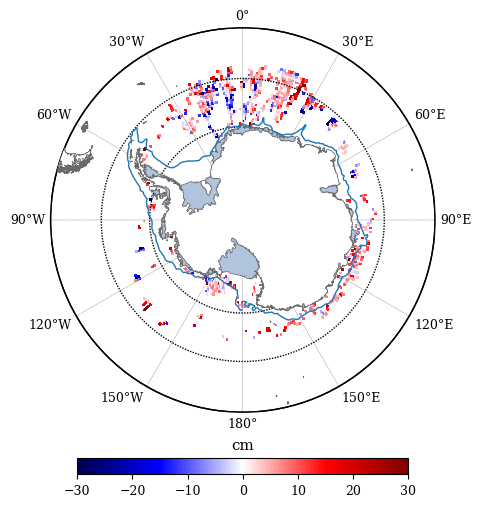

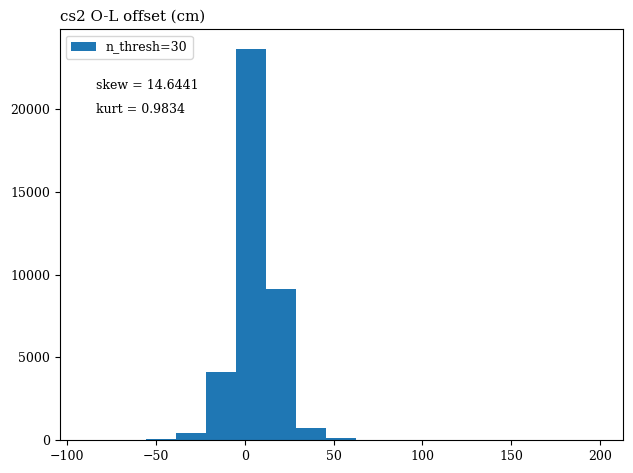

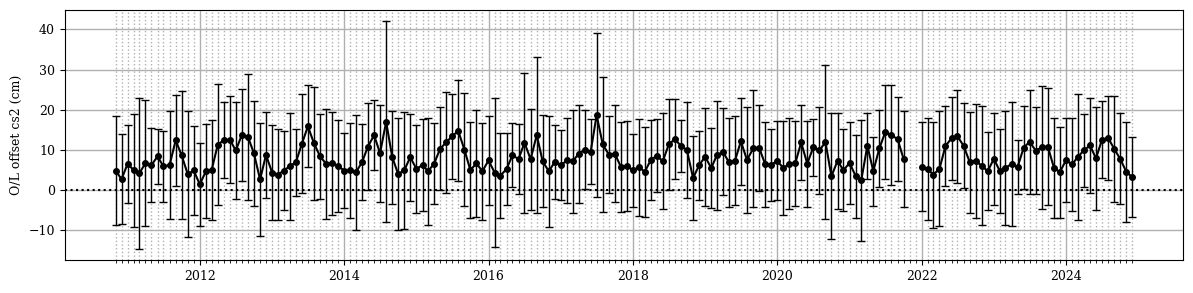

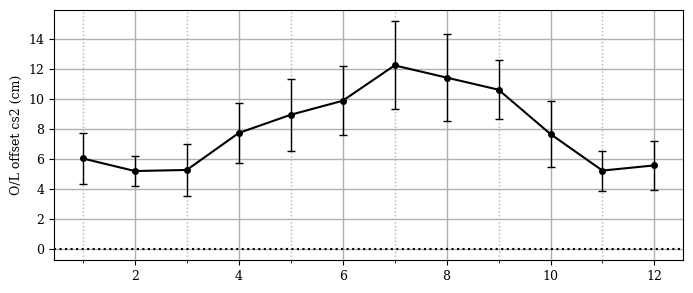

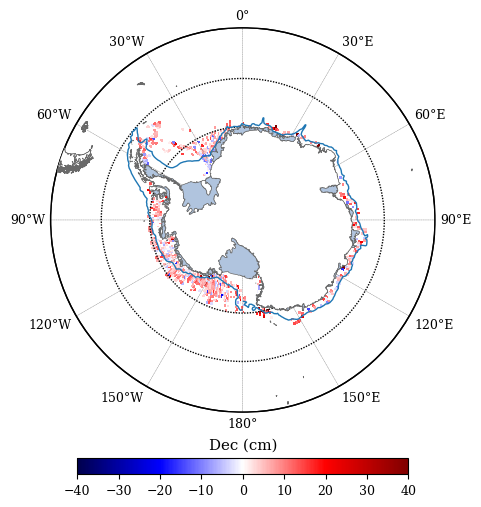

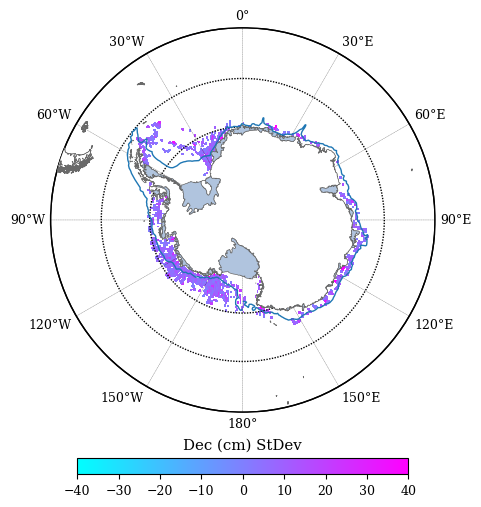

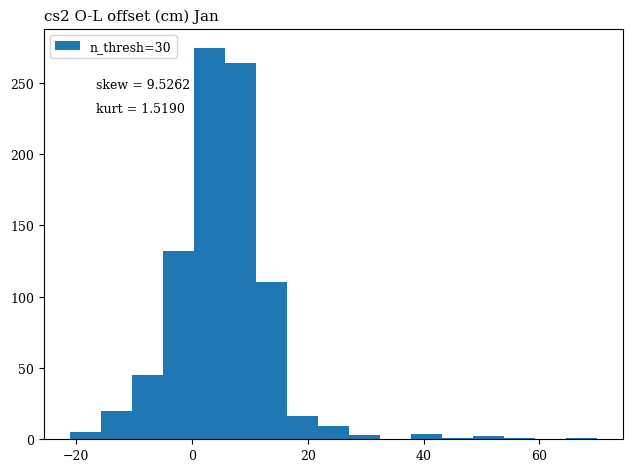

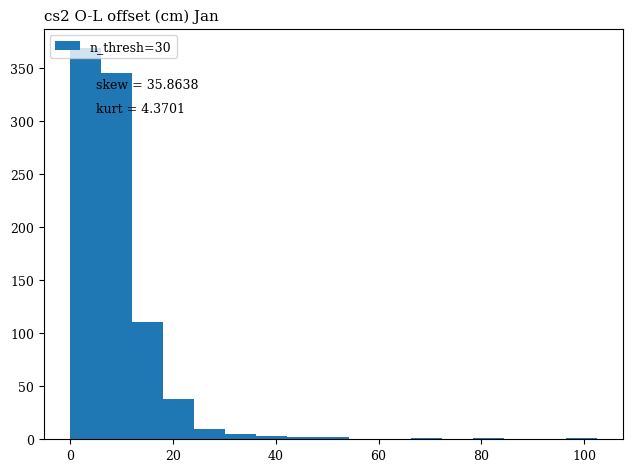

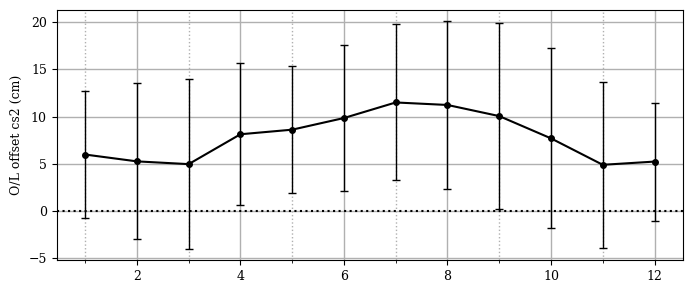

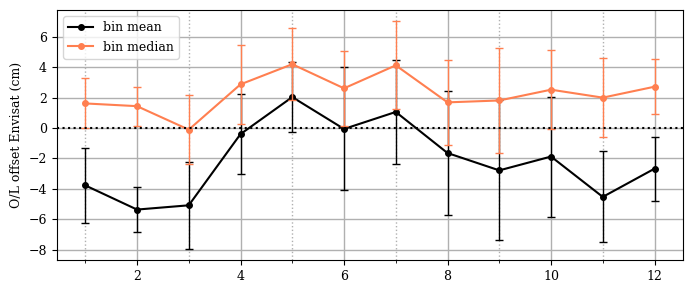

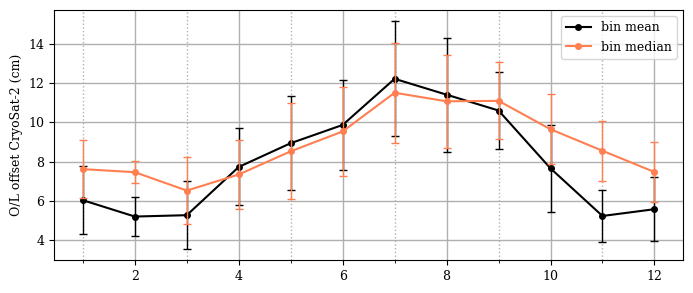

In [25]:
# B2 plots
"""
Plot of O/L offset climatology and Stdev
> for each satellite compare the offset when
using mean vs median as the bin statistic

Method: for every month we compute an area-weighted average offset
then we average the monthly means separately for every month
to obtain a climatology.
StDev is based on the spread of the area-weighted means over every month.

- save climatology in a file

Last modified: 10 Mar 2025
"""

## Import modules
import numpy as np
from numpy import ma
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import sys
import os

#-------------------------------------------------------------------
# Define directories
#-------------------------------------------------------------------
voldir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/'
ncdir = voldir + 'altimetry_cpom/1_raw_nc/'
bindir = voldir + 'altimetry_cpom/2_grid_offset/'

scriptdir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_scripts/'
auxscriptdir = scriptdir + 'aux_func/'

sys.path.append(auxscriptdir)
import aux_func as ft

#-------------------------------------------------------
# bin edges
edges_lon = np.linspace(-180, 180, num=361, endpoint=True)
edges_lat = np.linspace(-82, -50, num=65, endpoint=True)
eglat, eglon = np.meshgrid(edges_lat, edges_lon)

total_area = ft.grid_area(eglon, eglat)
#-------------------------------------------------------

def mclim(statistic, satellite, n_thresh):
    print("- - - - - - - - - - - - - - ")
    print("> > bin statistic: %s" % statistic)
    print("> > satellite: %s" % satellite)
    print("> > bin threshold: %s" % str(n_thresh))
    print("- - - - - - - - - - - - - - \n")

    #------------------------------------------------------------------
    filename = 'b01_bin_ssha_OL_' + satellite + '_' + str(statistic) + '.nc'
    print("File: %s" % filename)

    with xr.open_dataset(bindir + filename) as bin0:
        print(bin0.keys)

        #------------------------------------------------------------------
        # OFFSET computation
        #------------------------------------------------------------------
        bin0.ssha_o.values[bin0.npts_o < n_thresh] = np.nan
        bin0.ssha_l.values[bin0.npts_l < n_thresh] = np.nan

        offset = (bin0.ssha_o - bin0.ssha_l).transpose('longitude', 'latitude', 'time')
        offset.values[bin0.land_mask == 1] = np.nan
        offset = offset.to_dataset(name='ol_dif')

        ones = np.ones(offset.ol_dif.shape)
        ones[np.isnan(offset.ol_dif.values)] = 0
        arr_area = total_area[:, :, np.newaxis] * ones

        sum_area = arr_area.sum(axis=(0, 1))
        norm_area = arr_area / sum_area

        offset['weights'] = (('longitude', 'latitude', 'time'), norm_area)

        print(offset.keys())

        weighted_obj = offset.ol_dif.weighted(offset.weights)
        monthly_off_weighted = weighted_obj.mean(('longitude', 'latitude'))

        monthly_res_sq = (offset.ol_dif - monthly_off_weighted) ** 2
        weighted_obj_res_sq = monthly_res_sq.weighted(offset.weights)
        monthly_variance_weighted = weighted_obj_res_sq.mean(('longitude', 'latitude'))
        monthly_std_weighted = np.sqrt(monthly_variance_weighted)

        monthly_off_clim = monthly_off_weighted.groupby('time.month').mean('time')
        monthly_off_clim_std = monthly_off_weighted.groupby('time.month').std('time')

        ds = xr.Dataset(
            {
                'ol_dif': ('month', monthly_off_clim.values),
                'ol_std': ('month', monthly_off_clim_std.values)
            },
            coords={'month': np.arange(1, 13)}
        )

        newfile = 'b02_OL_offset_' + satellite + '_' + str(n_thresh) + statistic + '.nc'
        full_path = os.path.join(bindir, newfile)

        if os.path.exists(full_path):
            print(f"File {newfile} already exists. Skipping save.")
        else:
            ds.to_netcdf(full_path)
            print("File %s saved in %s" % (newfile, bindir))

    return ds

#-------------------------------------------------------
mean_env = mclim('mean', 'env', 30)
median_env = mclim('median', 'env', 30)

mean_cs2 = mclim('mean', 'cs2', 30)
median_cs2 = mclim('median', 'cs2', 30)

#-------------------------------------------------------
xtim = mean_env.month.values
fig, ax = plt.subplots(figsize=(7, 3))

ax.plot(xtim, mean_env.ol_dif.values * 1e2,
        c='k', marker='o', markersize=4, label='bin mean')
ax.errorbar(xtim, mean_env.ol_dif.values * 1e2,
            yerr=mean_env.ol_std.values * 1e2,
            capsize=3, ecolor='k', color='none', lw=1.)
ax.plot(xtim, median_env.ol_dif.values * 1e2,
        c='coral', marker='o', markersize=4, label='bin median')
ax.errorbar(xtim, median_env.ol_dif.values * 1e2,
            yerr=median_env.ol_std.values * 1e2,
            capsize=3, ecolor='coral', color='none', lw=1.)

ax.set_xticks(xtim, minor=True)
ax.grid(True, which='major', lw=1., ls='-')
ax.grid(True, which='minor', lw=1., ls=':')
ax.set_ylabel("O/L offset Envisat (cm)")
ax.axhline(0, ls=':', c='k')
ax.legend()
plt.tight_layout()

#-------------------------------------------------------
xtim = mean_cs2.month.values
fig, ax = plt.subplots(figsize=(7, 3))

ax.plot(xtim, mean_cs2.ol_dif.values * 1e2,
        c='k', marker='o', markersize=4, label='bin mean')
ax.errorbar(xtim, mean_cs2.ol_dif.values * 1e2,
            yerr=mean_cs2.ol_std.values * 1e2,
            capsize=3, ecolor='k', color='none', lw=1.)
ax.plot(xtim, median_cs2.ol_dif.values * 1e2,
        c='coral', marker='o', markersize=4, label='bin median')
ax.errorbar(xtim, median_cs2.ol_dif.values * 1e2,
            yerr=median_cs2.ol_std.values * 1e2,
            capsize=3, ecolor='coral', color='none', lw=1.)

ax.set_xticks(xtim, minor=True)
ax.grid(True, which='major', lw=1., ls='-')
ax.grid(True, which='minor', lw=1., ls=':')
ax.set_ylabel("O/L offset CryoSat-2 (cm)")
ax.legend()
plt.tight_layout()
plt.show()


In [26]:

#B3
"""
Create files with gridded LRM/SAR/SARin data from CS2 (after 2010.11)
after correcting the along-track SLA leads.

- correct for O/L
- grid retrackers separately
- save arrays in a new file

OFFSET:
- discard data less than 10km away from land
- bin ocean/leads separately
     (compute mean/median of lat, lon, ssh, mss in every cell;
      interp to cell centre after the land mask)
- apply gridded land mask (for the points that might be inside contours)

- test difference between mean/median average in bins; how do I treat the monthly std?
- compute monthly climatology + error estimate for every point


Last modified: 10 Mar 2025
"""

## libraries go here
import numpy as np
from numpy import ma

from datetime import datetime
today = datetime.today()

import time as runtime
t_start = runtime.process_time()

from scipy.stats import binned_statistic_2d as bin2d

import xarray as xr
import pandas as pd


import os
import sys

# Define directories
#-------------------------------------------------------------------------------
voldir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/'
ncdir = voldir + 'altimetry_cpom/1_raw_nc/'
bindir = voldir + 'altimetry_cpom/2_grid_offset/'
lmdir = voldir + 'land_masks/'

scriptdir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_scripts/'
auxscriptdir = scriptdir + 'aux_func/'



sys.path.append(auxscriptdir)
from aux_1_filenames import cs2_id_list
filenames = cs2_id_list

#-------------------------------------------------------------------------------
time = pd.date_range('2010-11-01', '2024-12-01', freq='1MS')

itt = len(time)
yr = time.year.values
months = time.month.values

#-------------------------------------------------------------------------------
# LAND MASK
#-------------------------------------------------------------------------------
# lon grid is -180/180, 0.5 lat x 1 lon
# lm shape=(mid_lon, mid_lat)
# land=1, ocean=0
#-------------------------------------------------------------------------------
lm = xr.open_dataset(lmdir+'land_mask_gridded_50s.nc')
lmask = lm.landmask.values

#------------------------------------------------------------------
# GRID
#------------------------------------------------------------------
# bin edges
edges_lon = np.linspace(-180, 180, num=361, endpoint=True)
edges_lat = np.linspace(-82, -50, num=65, endpoint=True)
eglat, eglon = np.meshgrid(edges_lat, edges_lon)

# bin centres
mid_lon = 0.5*(edges_lon[1:] + edges_lon[:-1])
mid_lat = 0.5*(edges_lat[1:] + edges_lat[:-1])
glat, glon = np.meshgrid(mid_lat, mid_lon)

londim, latdim = glat.shape

# # # # # # # # # # # #
statistic = 'median'
# # # # # # # # # # # #

print("- - - - - - - - - - - - - - ")
print("> > bin statistic: %s" % statistic)
print("- - - - - - - - - - - - - - \n")
#------------------------------------------------------------------
# OL offset
#------------------------------------------------------------------
with xr.open_dataset(bindir + 'b02_OL_offset_cs2_30' + statistic +'.nc') as offset:
    print(offset.keys())


ol_offset = offset.ol_dif.values

ssha_sar_all, ssha_sarin_all = [np.zeros((itt, londim, latdim)) for _ in range(2)]
npts_sar_all, npts_sarin_all = [np.zeros((itt, londim, latdim)) for _ in range(2)]

for j, filename in enumerate(filenames):
    print(filename)

    filepath = ncdir + filename + '.nc'

    try:
        ds = xr.open_dataset(filepath)

        # Check that required variables are present and dataset is not empty
        required_vars = ['Latitude', 'Longitude', 'Elevation', 'SurfaceType', 'distance_m', 'MeanSSH', 'Time']
        if not all(var in ds.variables for var in required_vars) or ds.sizes == {}:
            print(f"MERGE {filename} is empty or missing required variables")
            continue

    except FileNotFoundError:
        print(f"MERGE {filename} not available")
        continue


    lat = ds.Latitude.values
    lon = ds.Longitude.values
    ssh = ds.Elevation.values
    surf = ds.SurfaceType.values
    dist = ds.distance_m.values
    mss = ds.MeanSSH.values
    retrack = ds.Retracker.values

    # time start-end date
    print("date start: %s" % ds.Time[0].dt.strftime('%m.%Y').values)
    print("date end: %s" % ds.Time[-1].dt.strftime('%m.%Y').values)

    if (ds.Time[0].dt.year.values != yr[j]
        or ds.Time[0].dt.month.values != months[j]):
        print("Year or month do not agree with time coordinate!")
        sys.exit()
    #------------------------------------------------------------------
    # 1 keep only data further than 10km from nearest coastline
    #------------------------------------------------------------------
    ssh = ssh[dist>1e4]
    lon = lon[dist>1e4]
    lat = lat[dist>1e4]
    mss = mss[dist>1e4]
    surf = surf[dist>1e4]
    retrack = retrack[dist>1e4]

    ssha = ssh-mss

    #------------------------------------------------------------------
    # 2 add OL offset to along-track lead SLA
    #------------------------------------------------------------------
    # add the monthly climatology correction to the along_track leads
    month = ds.Time.dt.month.values[j]

    ssha[surf==2] += ol_offset[month-1]

    #------------------------------------------------------------------
    # 3 split into retrackers; level SAR/SARIn to start with
    #------------------------------------------------------------------
    ssha_sar = ssha[retrack==2]
    lon_sar = lon[retrack==2]
    lat_sar = lat[retrack==2]

    ssha_sarin = ssha[retrack==3]
    lon_sarin = lon[retrack==3]
    lat_sarin = lat[retrack==3]

    #------------------------------------------------------------------
    # 4. BIN DATA
    #------------------------------------------------------------------
    print("binning SAR data ..")
    x, y, var = lon_sar, lat_sar, ssha_sar
    ssha_sar_bin = bin2d(x, y, var, statistic=statistic,
                 bins=[edges_lon, edges_lat]).statistic
    # number of points in bins
    npts_sar = np.histogram2d(x, y, bins=(edges_lon, edges_lat))[0]

    print("binning SARIn data ..")
    x, y, var = lon_sarin, lat_sarin, ssha_sarin
    ssha_sarin_bin = bin2d(x, y, var, statistic=statistic,
                 bins=[edges_lon, edges_lat]).statistic
    # number of points in bins
    npts_sarin = np.histogram2d(x, y, bins=(edges_lon, edges_lat))[0]

    #------------------------------------------------------------------
    # 5. gridded land mask
    #------------------------------------------------------------------
    ssha_sar_bin[lmask==1] = np.nan
    ssha_sarin_bin[lmask==1] = np.nan
    npts_sar[lmask==1] = 0
    npts_sarin[lmask==1] = 0

    ssha_sar_all[j, :, :] = ssha_sar_bin
    ssha_sarin_all[j, :, :] = ssha_sarin_bin
    npts_sar_all[j, :, :] = npts_sar
    npts_sarin_all[j, :, :] = npts_sarin

# save SLA in a pkl file
ds_all = xr.Dataset({'ssha_sar' : (('time', 'longitude', 'latitude'), ssha_sar_all),
                     'ssha_sarin' : (('time', 'longitude', 'latitude'), ssha_sarin_all),
                     'npts_sar' : (('time', 'longitude', 'latitude'), npts_sar_all),
                     'npts_sarin' : (('time', 'longitude', 'latitude'), npts_sarin_all),
                     'land_mask' : (('longitude', 'latitude'), lmask)},
                    coords={'longitude' : mid_lon,
                            'latitude' : mid_lat,
                            'time' : time})

newfilename = 'b03_bin_ssha_SAR_cs2_' + statistic + '.nc'
fullpath = bindir + newfilename

if not os.path.exists(fullpath):
    ds_all.to_netcdf(fullpath)
else:
    print(f"File '{newfilename}' already exists. Skipping save.")

t_stop = runtime.process_time()
print("execution time: %.1f min " %((t_stop-t_start)/60))

print('The end.')


- - - - - - - - - - - - - - 
> > bin statistic: median
- - - - - - - - - - - - - - 

KeysView(<xarray.Dataset> Size: 288B
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    ol_dif   (month) float64 96B ...
    ol_std   (month) float64 96B ...)
201011_MERGE
date start: 11.2010
date end: 11.2010
binning SAR data ..
binning SARIn data ..
201012_MERGE
date start: 12.2010
date end: 12.2010
binning SAR data ..
binning SARIn data ..
201101_MERGE
date start: 01.2011
date end: 01.2011
binning SAR data ..
binning SARIn data ..
201102_MERGE
date start: 02.2011
date end: 02.2011
binning SAR data ..
binning SARIn data ..
201103_MERGE
date start: 03.2011
date end: 03.2011
binning SAR data ..
binning SARIn data ..
201104_MERGE
date start: 04.2011
date end: 04.2011
binning SAR data ..
binning SARIn data ..
201105_MERGE
date start: 05.2011
date end: 05.2011
binning SAR data ..
binning SARIn data ..
201106_MERGE
date start: 06.2011
date en

- - - - - - - - - - - - - - 
> > bin statistic: mean
> > bin threshold: 30
- - - - - - - - - - - - - - 

File: b03_bin_ssha_SAR_cs2_mean.nc
<bound method Mapping.keys of <xarray.Dataset> Size: 126MB
Dimensions:     (time: 170, longitude: 360, latitude: 64)
Coordinates:
  * longitude   (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude    (latitude) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
  * time        (time) datetime64[ns] 1kB 2010-11-01 2010-12-01 ... 2024-12-01
Data variables:
    ssha_sar    (time, longitude, latitude) float64 31MB ...
    ssha_sarin  (time, longitude, latitude) float64 31MB ...
    npts_sar    (time, longitude, latitude) float64 31MB ...
    npts_sarin  (time, longitude, latitude) float64 31MB ...
    land_mask   (longitude, latitude) float64 184kB ...>
KeysView(<xarray.Dataset> Size: 63MB
Dimensions:    (longitude: 360, latitude: 64, time: 170)
Coordinates:
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 1

/var/folders/_b/mwrrgwfd7k53y4lg7_zfzvjm0000gp/T/ipykernel_6625/1812369422.py:72: RuntimeWarning: invalid value encountered in divide
  norm_area = arr_area/sum_area
/var/folders/_b/mwrrgwfd7k53y4lg7_zfzvjm0000gp/T/ipykernel_6625/1812369422.py:72: RuntimeWarning: invalid value encountered in divide
  norm_area = arr_area/sum_area


KeysView(<xarray.Dataset> Size: 63MB
Dimensions:    (longitude: 360, latitude: 64, time: 170)
Coordinates:
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
  * time       (time) datetime64[ns] 1kB 2010-11-01 2010-12-01 ... 2024-12-01
Data variables:
    sar_dif    (longitude, latitude, time) float64 31MB nan nan nan ... nan nan
    weights    (longitude, latitude, time) float64 31MB 0.0 0.0 0.0 ... 0.0 0.0)
File b03_SAR_offset_cs2_30median.nc already exists. Skipping save.


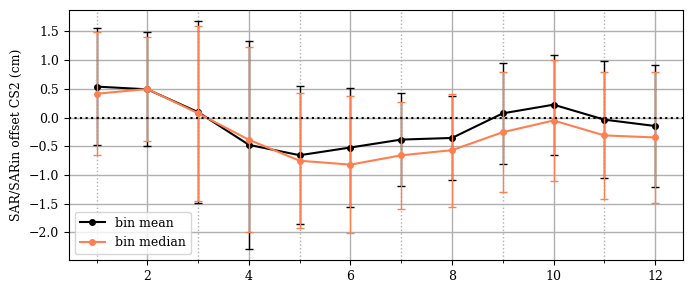

In [28]:
"""
Analyse the SAR/SARIn offset variability

Last modified: 30 Mar 2021
"""

## Import modules
import numpy as np
from numpy import ma

import matplotlib.pyplot as plt

import xarray as xr
import pandas as pd

import sys

#-------------------------------------------------------------------
# Define directories
#-------------------------------------------------------------------------------
voldir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/'
ncdir = voldir + 'altimetry_cpom/1_raw_nc/'
bindir = voldir + 'altimetry_cpom/2_grid_offset/'

scriptdir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_scripts/'
auxscriptdir = scriptdir + 'aux_func/'

sys.path.append(auxscriptdir)
import aux_func as ft

#-------------------------------------------------------
# bin edges
edges_lon = np.linspace(-180, 180, num=361, endpoint=True)
edges_lat = np.linspace(-82, -50, num=65, endpoint=True)
eglat, eglon = np.meshgrid(edges_lat, edges_lon)

total_area = ft.grid_area(eglon, eglat)
#-------------------------------------------------------

def mclim(statistic, n_thresh):
    print("- - - - - - - - - - - - - - ")
    print("> > bin statistic: %s" % statistic)
    print("> > bin threshold: %s" % str(n_thresh))
    print("- - - - - - - - - - - - - - \n")

    #------------------------------------------------------------------
    filename = 'b03_bin_ssha_SAR_cs2_' + statistic + '.nc'
    print("File: %s" % filename)

    with xr.open_dataset(bindir + filename) as bin0:
        print(bin0.keys)

    #------------------------------------------------------------------
    # OFFSET computation
    #------------------------------------------------------------------
    # discard bins with fewer points than a certain threshold
    bin0.ssha_sar.values[bin0.npts_sar<n_thresh] = np.nan
    bin0.ssha_sarin.values[bin0.npts_sarin<n_thresh] = np.nan

    # subtract leads from ocean
    offset = (bin0.ssha_sar - bin0.ssha_sarin).transpose('longitude', 'latitude', 'time')
    offset.values[bin0.land_mask==1] = np.nan
    offset = offset.to_dataset(name='sar_dif')

    # create weights based on the surface area of each bin
    ones = np.ones(offset.sar_dif.shape)
    ones[np.isnan(offset.sar_dif.values)] = 0
    arr_area = total_area[:,:, np.newaxis]*ones

    # normalize weights
    sum_area = arr_area.sum(axis=(0,1))
    norm_area = arr_area/sum_area

    offset['weights'] = (('longitude', 'latitude', 'time'), norm_area)

    #- - - - - - - - - - - - - -
    print(offset.keys())
    #- - - - - - - - - - - - - -

    # > > a. area weighted mean and StDev for every month
    # results are the same as my implementation of the weighted avg
    weighted_obj = offset.sar_dif.weighted(offset.weights)
    monthly_off_weighted = weighted_obj.mean(('longitude', 'latitude'))

    monthly_res_sq = (offset.sar_dif - monthly_off_weighted)**2
    weighted_obj_res_sq = monthly_res_sq.weighted(offset.weights)
    monthly_variance_weighted = weighted_obj_res_sq.mean(('longitude', 'latitude'))
    monthly_std_weighted = np.sqrt(monthly_variance_weighted)

    # a. climatology of monthly area-weighted mean offset
    monthly_off_clim = monthly_off_weighted.groupby('time.month').mean('time')

    # TWO ways to compute StDev!!! ????
    #monthly_off_clim_std = monthly_std_weighted.groupby('time.month').mean('time')
    monthly_off_clim_std = monthly_off_weighted.groupby('time.month').std('time')

    ds = xr.Dataset({'sar_dif' : ('month', monthly_off_clim.values),
        'sar_std' : ('month', monthly_off_clim_std.values)},
        coords={'month' : np.arange(1,13)})

    newfile = 'b03_SAR_offset_cs2_' + str(n_thresh) + statistic + '.nc'
    full_path = bindir + newfile

    if os.path.exists(full_path):
        print(f"File {newfile} already exists. Skipping save.")
    else:
        ds.to_netcdf(full_path)
        print("File %s saved in %s" % (newfile, bindir))

    return ds

#-------------------------------------------------------
mean_sar = mclim('mean', 30)
median_sar = mclim('median', 30)


xtim = mean_sar.month.values
fig, ax = plt.subplots(figsize=(7,3))

ax.plot(xtim,
        mean_sar.sar_dif.values*1e2,
        c='k', marker='o', markersize=4,
        label='bin mean')
ax.errorbar(xtim,
            mean_sar.sar_dif.values*1e2,
            yerr=mean_sar.sar_std.values*1e2,
            capsize=3, ecolor='k',
            color='none', lw=1.)
ax.plot(xtim,
       median_sar.sar_dif.values*1e2,
       c='coral', marker='o', markersize=4,
       label='bin median')
ax.errorbar(xtim,
           median_sar.sar_dif.values*1e2,
           yerr=median_sar.sar_std.values*1e2,
           capsize=3, ecolor='coral',
           color='none', lw=1.)

ax.set_xticks(xtim, minor=True)
ax.grid(True, which='major', lw=1., ls='-')
ax.grid(True, which='minor', lw=1., ls=':')
ax.set_ylabel("SAR/SARin offset CS2 (cm)")
ax.axhline(0, ls=':', c='k')
ax.legend()
plt.tight_layout()
plt.show()

In [29]:
#B4
"""
Create files with gridded LRM/SAR(In) data from CS2 (after 2010.11)
after correcting the along-track SLA leads.

- correct SARIn to level to SAR
- bin LRM and SAR/SARIn separately

OFFSET:
- discard data less than 10km away from land
- bin ocean/leads separately
- apply gridded land mask (for the points that might be inside contours)
- test difference between mean/median average in bins; how do I treat the monthly std?

Last modified: 31 Mar 2021
"""

## libraries go here
import numpy as np
from numpy import ma

from datetime import datetime
today = datetime.today()

import time as runtime
t_start = runtime.process_time()

from scipy.stats import binned_statistic_2d as bin2d

import xarray as xr
import pandas as pd

import sys

#-------------------------------------------------------------------
# Define directories
#-------------------------------------------------------------------------------
voldir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/'
ncdir = voldir + 'altimetry_cpom/1_raw_nc/'
bindir = voldir + 'altimetry_cpom/2_grid_offset/'
lmdir = voldir + 'land_masks/'

scriptdir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_scripts/'
auxscriptdir = scriptdir + 'aux_func/'

sys.path.append(auxscriptdir)
from aux_1_filenames import cs2_id_list
filenames = cs2_id_list
#-------------------------------------------------------------------------------

time = pd.date_range('2010-11-01', '2024-12-01', freq='1MS')

itt = len(time)
yr = time.year.values
months = time.month.values

#-------------------------------------------------------------------------------
# LAND MASK
#-------------------------------------------------------------------------------
# lon grid is -180/180, 0.5 lat x 1 lon
# lm shape=(mid_lon, mid_lat)
# land=1, ocean=0
#-------------------------------------------------------------------------------
lm = xr.open_dataset(lmdir+'land_mask_gridded_50s.nc')
lmask = lm.landmask.values

#------------------------------------------------------------------
# GRID
#------------------------------------------------------------------
# bin edges
edges_lon = np.linspace(-180, 180, num=361, endpoint=True)
edges_lat = np.linspace(-82, -50, num=65, endpoint=True)
eglat, eglon = np.meshgrid(edges_lat, edges_lon)

# bin centres
mid_lon = 0.5*(edges_lon[1:] + edges_lon[:-1])
mid_lat = 0.5*(edges_lat[1:] + edges_lat[:-1])
glat, glon = np.meshgrid(mid_lat, mid_lon)

londim, latdim = glat.shape

# # # # # # # # # # # #
statistic = 'mean'
# # # # # # # # # # # #

print("- - - - - - - - - - - - - - ")
print("> > bin statistic: %s" % statistic)
print("- - - - - - - - - - - - - - \n")
#------------------------------------------------------------------
# OL offset
#------------------------------------------------------------------
with xr.open_dataset(bindir + 'b02_OL_offset_cs2_30' + statistic +'.nc') as offset:
    print(offset.keys())

ol_offset = offset.ol_dif.values

#------------------------------------------------------------------
# SAR/SARIn offset
#------------------------------------------------------------------
with xr.open_dataset(bindir + 'b03_SAR_offset_cs2_30' + statistic +'.nc') as offset:
    print(offset.keys())

sarin_offset = offset.sar_dif.values

#------------------------------------------------------------------
ssha_sar_all, ssha_lrm_all = [np.zeros((itt, londim, latdim)) for _ in range(2)]
npts_sar_all, npts_lrm_all = [np.zeros((itt, londim, latdim)) for _ in range(2)]

for j, filename in enumerate(filenames):
    print(filename)

    filepath = ncdir + filename + '.nc'

    try:
        ds = xr.open_dataset(filepath)

        # Check that required variables are present and dataset is not empty
        required_vars = ['Latitude', 'Longitude', 'Elevation', 'SurfaceType', 'distance_m', 'MeanSSH', 'Time']
        if not all(var in ds.variables for var in required_vars) or ds.sizes == {}:
            print(f"MERGE {filename} is empty or missing required variables")
            continue

    except FileNotFoundError:
        print(f"MERGE {filename} not available")
        continue

    lat = ds.Latitude.values
    lon = ds.Longitude.values
    ssh = ds.Elevation.values
    surf = ds.SurfaceType.values
    dist = ds.distance_m.values
    mss = ds.MeanSSH.values
    retrack = ds.Retracker.values

    # time start-end date
    print("date start: %s" % ds.Time[0].dt.strftime('%m.%Y').values)
    print("date end: %s" % ds.Time[-1].dt.strftime('%m.%Y').values)

    if (ds.Time[0].dt.year.values != yr[j]
        or ds.Time[0].dt.month.values != months[j]):
        print("Year or month do not agree with time coordinate!")
        sys.exit()
    #------------------------------------------------------------------
    # 1 keep only data further than 10km from nearest coastline
    #------------------------------------------------------------------
    ssh = ssh[dist>1e4]
    lon = lon[dist>1e4]
    lat = lat[dist>1e4]
    mss = mss[dist>1e4]
    surf = surf[dist>1e4]
    retrack = retrack[dist>1e4]

    ssha = ssh-mss

    #------------------------------------------------------------------
    # 2 add OL offset to along-track lead SLA
    #------------------------------------------------------------------
    # add the monthly climatology correction to the along_track leads
    month = ds.Time.dt.month.values[j]

    ssha[surf==2] += ol_offset[month-1]
    ssha[retrack==3] += sarin_offset[month-1]

    #------------------------------------------------------------------
    # 3 split into retrackers
    #------------------------------------------------------------------
    ssha_lrm = ssha[retrack==1]
    lon_lrm = lon[retrack==1]
    lat_lrm = lat[retrack==1]

    ssha_sar = ssha[retrack!=1]
    lon_sar = lon[retrack!=1]
    lat_sar = lat[retrack!=1]

    #------------------------------------------------------------------
    # 4. BIN DATA
    #------------------------------------------------------------------
    print("binning LRM data ..")
    x, y, var = lon_lrm, lat_lrm, ssha_lrm
    ssha_lrm_bin = bin2d(x, y, var, statistic=statistic,
                 bins=[edges_lon, edges_lat]).statistic
    # number of points in bins
    npts_lrm = np.histogram2d(x, y, bins=(edges_lon, edges_lat))[0]

    print("binning SAR data ..")
    x, y, var = lon_sar, lat_sar, ssha_sar
    ssha_sar_bin = bin2d(x, y, var, statistic=statistic,
                 bins=[edges_lon, edges_lat]).statistic
    # number of points in bins
    npts_sar = np.histogram2d(x, y, bins=(edges_lon, edges_lat))[0]

    #------------------------------------------------------------------
    # 5. gridded land mask
    #------------------------------------------------------------------
    ssha_lrm_bin[lmask==1] = ma.masked
    ssha_sar_bin[lmask==1] = ma.masked
    npts_sar[lmask==1] = 0
    npts_lrm[lmask==1] = 0

    ssha_sar_all[j, :, :] = ssha_sar_bin
    ssha_lrm_all[j, :, :] = ssha_lrm_bin
    npts_sar_all[j, :, :] = npts_sar
    npts_lrm_all[j, :, :] = npts_lrm

# save SLA in a pkl file
ds_all = xr.Dataset({'ssha_lrm' : (('time', 'longitude', 'latitude'), ssha_lrm_all),
                     'ssha_sar' : (('time', 'longitude', 'latitude'), ssha_sar_all),
                     'npts_sar' : (('time', 'longitude', 'latitude'), npts_sar_all),
                     'npts_lrm' : (('time', 'longitude', 'latitude'), npts_lrm_all),
                     'land_mask' : (('longitude', 'latitude'), lmask)},
                    coords={'longitude' : mid_lon,
                            'latitude' : mid_lat,
                            'time' : time})
newfile = 'b04_bin_ssha_LRM_cs2_' + statistic +'.nc'
full_path = bindir + newfile

if os.path.exists(full_path):
    print(f"File {full_path} already exists")
else:
    ds.to_netcdf(full_path)
    print(f"File {full_path} created")


t_stop = runtime.process_time()
print("execution time: %.1f min " %((t_stop-t_start)/60))

print('The end.')


- - - - - - - - - - - - - - 
> > bin statistic: mean
- - - - - - - - - - - - - - 

KeysView(<xarray.Dataset> Size: 288B
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    ol_dif   (month) float64 96B ...
    ol_std   (month) float64 96B ...)
KeysView(<xarray.Dataset> Size: 288B
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sar_dif  (month) float64 96B ...
    sar_std  (month) float64 96B ...)
201011_MERGE
date start: 11.2010
date end: 11.2010
binning LRM data ..
binning SAR data ..
201012_MERGE
date start: 12.2010
date end: 12.2010
binning LRM data ..
binning SAR data ..
201101_MERGE
date start: 01.2011
date end: 01.2011
binning LRM data ..
binning SAR data ..
201102_MERGE
date start: 02.2011
date end: 02.2011
binning LRM data ..
binning SAR data ..
201103_MERGE
date start: 03.2011
date end: 03.2011
binning LRM data ..
binning SAR data ..
201104_MERGE
d

- - - - - - - - - - - - - - 
> > bin statistic: mean
> > bin threshold: 30
- - - - - - - - - - - - - - 

File: b04_bin_ssha_LRM_cs2_mean.nc
<bound method Mapping.keys of <xarray.Dataset> Size: 126MB
Dimensions:    (time: 170, longitude: 360, latitude: 64)
Coordinates:
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
  * time       (time) datetime64[ns] 1kB 2010-11-01 2010-12-01 ... 2024-12-01
Data variables:
    ssha_lrm   (time, longitude, latitude) float64 31MB ...
    ssha_sar   (time, longitude, latitude) float64 31MB ...
    npts_sar   (time, longitude, latitude) float64 31MB ...
    npts_lrm   (time, longitude, latitude) float64 31MB ...
    land_mask  (longitude, latitude) float64 184kB ...>
KeysView(<xarray.Dataset> Size: 63MB
Dimensions:    (longitude: 360, latitude: 64, time: 170)
Coordinates:
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * 

/var/folders/_b/mwrrgwfd7k53y4lg7_zfzvjm0000gp/T/ipykernel_6625/729592418.py:74: RuntimeWarning: invalid value encountered in divide
  norm_area = arr_area/sum_area
/var/folders/_b/mwrrgwfd7k53y4lg7_zfzvjm0000gp/T/ipykernel_6625/729592418.py:74: RuntimeWarning: invalid value encountered in divide
  norm_area = arr_area/sum_area


KeysView(<xarray.Dataset> Size: 63MB
Dimensions:    (longitude: 360, latitude: 64, time: 170)
Coordinates:
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
  * time       (time) datetime64[ns] 1kB 2010-11-01 2010-12-01 ... 2024-12-01
Data variables:
    lrm_dif    (longitude, latitude, time) float64 31MB nan nan nan ... nan nan
    weights    (longitude, latitude, time) float64 31MB 0.0 0.0 0.0 ... 0.0 0.0)
File b04_LRM_offset_cs2_30median.nc already exists


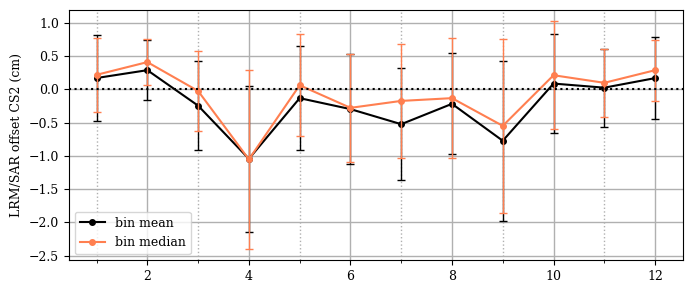

In [30]:
"""
Analyse the LRM/SAR(In) offset variability

Last modified: 31 Mar 2021
"""

## Import modules
import numpy as np
from numpy import ma

import matplotlib.pyplot as plt

import xarray as xr
import pandas as pd

import sys

#-------------------------------------------------------------------
# Define directories
#-------------------------------------------------------------------
voldir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/'
ncdir = voldir + 'altimetry_cpom/1_raw_nc/'
bindir = voldir + 'altimetry_cpom/2_grid_offset/'
lmdir = voldir + 'land_masks/'

scriptdir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_scripts/'
auxscriptdir = scriptdir + 'aux_func/'

sys.path.append(auxscriptdir)
# import aux_func_trend as ft
import aux_func as ft

#-------------------------------------------------------
# bin edges
edges_lon = np.linspace(-180, 180, num=361, endpoint=True)
edges_lat = np.linspace(-82, -50, num=65, endpoint=True)
eglat, eglon = np.meshgrid(edges_lat, edges_lon)

total_area = ft.grid_area(eglon, eglat)
#-------------------------------------------------------

def mclim(statistic, n_thresh):
    print("- - - - - - - - - - - - - - ")
    print("> > bin statistic: %s" % statistic)
    print("> > bin threshold: %s" % str(n_thresh))
    print("- - - - - - - - - - - - - - \n")

    #------------------------------------------------------------------
    filename = 'b04_bin_ssha_LRM_cs2_' + statistic + '.nc'
    print("File: %s" % filename)

    with xr.open_dataset(bindir + filename) as bin0:
        print(bin0.keys)

    #------------------------------------------------------------------
    # OFFSET computation
    #------------------------------------------------------------------
    # discard bins with fewer points than a certain threshold
    bin0.ssha_lrm.values[bin0.npts_lrm<n_thresh] = np.nan
    bin0.ssha_sar.values[bin0.npts_sar<n_thresh] = np.nan

    # subtract leads from ocean
    offset = (bin0.ssha_lrm - bin0.ssha_sar).transpose('longitude', 'latitude', 'time')
    offset.values[bin0.land_mask==1] = np.nan
    offset = offset.to_dataset(name='lrm_dif')

    # create weights based on the surface area of each bin
    ones = np.ones(offset.lrm_dif.shape)
    ones[np.isnan(offset.lrm_dif.values)] = 0
    arr_area = total_area[:,:, np.newaxis]*ones

    # normalize weights
    sum_area = arr_area.sum(axis=(0,1))
    norm_area = arr_area/sum_area

    offset['weights'] = (('longitude', 'latitude', 'time'), norm_area)

    #- - - - - - - - - - - - - -
    print(offset.keys())
    #- - - - - - - - - - - - - -

    # > > a. area weighted mean and StDev for every month
    # results are the same as my implementation of the weighted avg
    weighted_obj = offset.lrm_dif.weighted(offset.weights)
    monthly_off_weighted = weighted_obj.mean(('longitude', 'latitude'))

    monthly_res_sq = (offset.lrm_dif - monthly_off_weighted)**2
    weighted_obj_res_sq = monthly_res_sq.weighted(offset.weights)
    monthly_variance_weighted = weighted_obj_res_sq.mean(('longitude', 'latitude'))
    monthly_std_weighted = np.sqrt(monthly_variance_weighted)

    # a. climatology of monthly area-weighted mean offset
    monthly_off_clim = monthly_off_weighted.groupby('time.month').mean('time')

    # TWO ways to compute StDev!!! ????
    #monthly_off_clim_std = monthly_std_weighted.groupby('time.month').mean('time')
    monthly_off_clim_std = monthly_off_weighted.groupby('time.month').std('time')

    ds = xr.Dataset({'lrm_dif' : ('month', monthly_off_clim.values),
        'lrm_std' : ('month', monthly_off_clim_std.values)},
        coords={'month' : np.arange(1,13)})

    newfile = 'b04_LRM_offset_cs2_' + str(n_thresh) + statistic +'.nc'
    file_path = bindir + newfile

    if os.path.exists(file_path):
        print("File %s already exists" % newfile)
    else:
        ds.to_netcdf(file_path)
        print("File %s created" % newfile)


    return ds

#-------------------------------------------------------
mean_lrm = mclim('mean', 30)
median_lrm = mclim('median', 30)


xtim = mean_lrm.month.values
fig, ax = plt.subplots(figsize=(7,3))

ax.plot(xtim,
        mean_lrm.lrm_dif.values*1e2,
        c='k', marker='o', markersize=4,
        label='bin mean')
ax.errorbar(xtim,
            mean_lrm.lrm_dif.values*1e2,
            yerr=mean_lrm.lrm_std.values*1e2,
            capsize=3, ecolor='k',
            color='none', lw=1.)
ax.plot(xtim,
       median_lrm.lrm_dif.values*1e2,
       c='coral', marker='o', markersize=4,
       label='bin median')
ax.errorbar(xtim,
           median_lrm.lrm_dif.values*1e2,
           yerr=median_lrm.lrm_std.values*1e2,
           capsize=3, ecolor='coral',
           color='none', lw=1.)

ax.set_xticks(xtim, minor=True)
ax.grid(True, which='major', lw=1., ls='-')
ax.grid(True, which='minor', lw=1., ls=':')
ax.set_ylabel("LRM/SAR offset CS2 (cm)")
ax.axhline(0, ls=':', c='k')
ax.legend()
plt.tight_layout()
plt.show()


- - - - - - - - - - - - - - 
> > bin statistic: median
> > satellite: env
> > bin threshold: 30
- - - - - - - - - - - - - - 

<bound method Mapping.keys of <xarray.Dataset> Size: 86MB
Dimensions:    (time: 117, longitude: 360, latitude: 64)
Coordinates:
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
  * time       (time) datetime64[ns] 936B 2002-07-01 2002-08-01 ... 2012-03-01
Data variables:
    ssha_o     (time, longitude, latitude) float64 22MB ...
    ssha_l     (time, longitude, latitude) float64 22MB ...
    npts_o     (time, longitude, latitude) float64 22MB ...
    npts_l     (time, longitude, latitude) float64 22MB ...
    land_mask  (longitude, latitude) float64 184kB ...>

 PLOT: Stereographic projection of SLA - Ocean and Lead 



Text(0.5, 0.98, 'M/Y: 12/2003\n')

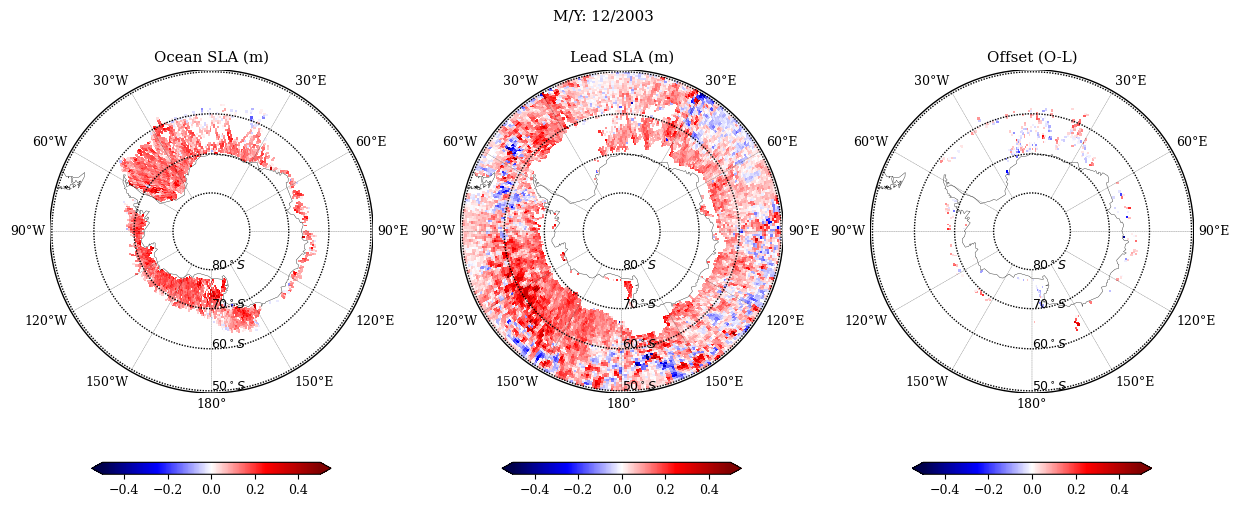

In [31]:
"""
Read binned ocean/lead files.
- discard bins that have less than 30 points
- compute and plot offset (O-L) - 3 plots side by side
- save figure

Last modified: 10 Mar 2025
"""

# Import modules
import numpy as np
from numpy import ma

import xarray as xr

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.basemap import Basemap

import sys
#-------------------------------------------------------------------
# Define directories
#-------------------------------------------------------------------
voldir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/'
ncdir = voldir + 'altimetry_cpom/1_raw_nc/'
bindir = voldir + 'altimetry_cpom/2_grid_offset/'
lmdir = voldir + 'land_masks/'

scriptdir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_scripts/'
auxscriptdir = scriptdir + 'aux_func/'


sys.path.append(auxscriptdir)
import aux_stereoplot as st
#- - - - - - - - - - - - - -

#-------------------------------------------------------
# bin edges
edges_lon = np.linspace(-180, 180, num=361, endpoint=True)
edges_lat = np.linspace(-82, -50, num=65, endpoint=True)
eglat, eglon = np.meshgrid(edges_lat, edges_lon)

m = Basemap(projection='spstere',
            boundinglat=-49.5,
            lon_0=-180,
            resolution='c',
            round=True,
            ellps='WGS84')
#-------------------------------------------------------

# # # # # # # # # # # #
statistic = 'median'
satellite = 'env'
n_thresh = 30
# # # # # # # # # # # #

print("- - - - - - - - - - - - - - ")
print("> > bin statistic: %s" % statistic)
print("> > satellite: %s" % satellite)
print("> > bin threshold: %s" % str(n_thresh))
print("- - - - - - - - - - - - - - \n")

#------------------------------------------------------------------
filename = 'b01_bin_ssha_OL_' + satellite + '_' + str(statistic) + '.nc'

with xr.open_dataset(bindir + filename) as bin0:
    print(bin0.keys)

bin0.ssha_o.values[bin0.npts_o<n_thresh] = np.nan
bin0.ssha_l.values[bin0.npts_l<n_thresh] = np.nan

#------------------------------------------------------------------
#                        STEREOGRAPHIC PLOT
print('\n PLOT: Stereographic projection of SLA - Ocean and Lead \n')
#------------------------------------------------------------------
# variables to plot
tim_idx = 17

var_O = bin0.ssha_o.isel(time=tim_idx)
var_L = bin0.ssha_l.isel(time=tim_idx)
var_dif = var_O - var_L

tim_month = bin0.time[tim_idx].dt.month.values
tim_year = bin0.time[tim_idx].dt.year.values

xx, yy = eglon, eglat

cmap = cm.seismic


plt.ion()
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 6), ncols=3)

ax1.set_title("Ocean SLA (m)")
ax2.set_title("Lead SLA (m)")
ax3.set_title("Offset (O-L)")

# pcolormesh: 2D array has x=rows, y=cols; matches with the grid
cs1 = m.pcolormesh(xx, yy, var_L,
                   cmap=cmap,
                   latlon=True, zorder=2,
                   vmin=-0.5, vmax=0.5,
                   rasterized=True, ax=ax1)
m.drawcoastlines(linewidth=0.25, zorder=4, ax=ax1)
m.drawparallels(np.arange(-80, -40, 10),
                zorder=3, linewdith=0.25, ax=ax1)
m.drawmeridians(np.arange(30., 360., 30.), zorder=3,
               labels=[1, 1, 1, 1], linewidth=0.25, ax=ax1)
plt.colorbar(cs1, ax=ax1, orientation='horizontal',
             extend='both', shrink=0.7)
# ----- #
cs2 = m.pcolormesh(xx, yy, var_O,
                   latlon=True,
                   cmap=cmap,
                   zorder=2, vmin=-0.5, vmax=0.5,
                   rasterized=True, ax=ax2)
m.drawcoastlines(linewidth=0.25, zorder=4, ax=ax2)
m.drawparallels(np.arange(-80, -40, 10),
                zorder=3, linewdith=0.25, ax=ax2)
m.drawmeridians(np.arange(30., 360., 30.), zorder=3,
               labels=[1, 1, 1, 1], linewidth=0.25, ax=ax2)
plt.colorbar(cs2, ax=ax2, orientation='horizontal',
             extend='both', shrink=0.7)

# ----- #
cs3 = m.pcolormesh(xx, yy, var_dif,
                   latlon=True,
                   cmap=cmap,
                   zorder=2,
                   vmin=-0.5, vmax=0.5,
                   rasterized=True, ax=ax3)
m.drawcoastlines(linewidth=0.25, zorder=4, ax=ax3)
m.drawparallels(np.arange(-80., -40., 10),
                zorder=3, linewdith=0.25, ax=ax3)
m.drawmeridians(np.arange(30., 360., 30.), zorder=3,
               labels=[1, 1, 1, 1], linewidth=0.25, ax=ax3)
plt.colorbar(cs3, ax=ax3, orientation='horizontal',
             extend='both', shrink=0.7)

for ax in (ax1, ax2, ax3):
    # annotate parallels
    x1, y1 = m(180, -80)
    ax.annotate(r"$80^\circ S$", xy=(x1, y1), xycoords='data',
            xytext=(x1, y1),textcoords='data')
    x2, y2 = m(180, -70)
    ax.annotate(r"$70^\circ S$", xy=(x2, y2), xycoords='data',
            xytext=(x2, y2),textcoords='data')
    x3, y3 = m(180, -60)
    ax.annotate(r"$60^\circ S$", xy=(x3, y3), xycoords='data',
            xytext=(x3, y3),textcoords='data')
    x4, y4 = m(180, -50)
    ax.annotate(r"$50^\circ S$", xy=(x4, y4), xycoords='data',
            xytext=(x4, y4),textcoords='data')
    ax.set_rasterization_zorder(0)

fig.suptitle(('{}{}{}{}{}').format('M/Y: ',
                                  tim_month, '/',
                                  tim_year, '\n'))


- - - - - - - - - - - - - - 
> > bin statistic: mean
> > bin threshold: 30
- - - - - - - - - - - - - - 

File: b03_bin_ssha_SAR_cs2_mean.nc
<bound method Mapping.keys of <xarray.Dataset> Size: 126MB
Dimensions:     (time: 170, longitude: 360, latitude: 64)
Coordinates:
  * longitude   (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude    (latitude) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
  * time        (time) datetime64[ns] 1kB 2010-11-01 2010-12-01 ... 2024-12-01
Data variables:
    ssha_sar    (time, longitude, latitude) float64 31MB ...
    ssha_sarin  (time, longitude, latitude) float64 31MB ...
    npts_sar    (time, longitude, latitude) float64 31MB ...
    npts_sarin  (time, longitude, latitude) float64 31MB ...
    land_mask   (longitude, latitude) float64 184kB ...>
KeysView(<xarray.Dataset> Size: 63MB
Dimensions:    (longitude: 360, latitude: 64, time: 170)
Coordinates:
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 1

/var/folders/_b/mwrrgwfd7k53y4lg7_zfzvjm0000gp/T/ipykernel_6625/1771553822.py:72: RuntimeWarning: invalid value encountered in divide
  norm_area = arr_area/sum_area
/var/folders/_b/mwrrgwfd7k53y4lg7_zfzvjm0000gp/T/ipykernel_6625/1771553822.py:72: RuntimeWarning: invalid value encountered in divide
  norm_area = arr_area/sum_area


KeysView(<xarray.Dataset> Size: 63MB
Dimensions:    (longitude: 360, latitude: 64, time: 170)
Coordinates:
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
  * time       (time) datetime64[ns] 1kB 2010-11-01 2010-12-01 ... 2024-12-01
Data variables:
    sar_dif    (longitude, latitude, time) float64 31MB nan nan nan ... nan nan
    weights    (longitude, latitude, time) float64 31MB 0.0 0.0 0.0 ... 0.0 0.0)
file saved in: /Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/altimetry_cpom/2_grid_offset/b03_SAR_offset_cs2_30median.nc
execution time: 1.7 min 


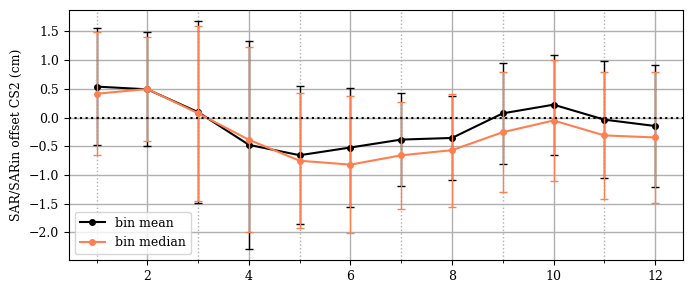

In [27]:
"""
Analyse the SAR/SARIn offset variability

Last modified: 30 Mar 2021
"""

## Import modules
import numpy as np
from numpy import ma

import matplotlib.pyplot as plt

import xarray as xr
import pandas as pd

import sys

#-------------------------------------------------------------------
# Define directories
#-------------------------------------------------------------------------------
voldir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/'
ncdir = voldir + 'altimetry_cpom/1_raw_nc/'
bindir = voldir + 'altimetry_cpom/2_grid_offset/'

scriptdir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_scripts/'
auxscriptdir = scriptdir + 'aux_func/'

sys.path.append(auxscriptdir)
import aux_func as ft

#-------------------------------------------------------
# bin edges
edges_lon = np.linspace(-180, 180, num=361, endpoint=True)
edges_lat = np.linspace(-82, -50, num=65, endpoint=True)
eglat, eglon = np.meshgrid(edges_lat, edges_lon)

total_area = ft.grid_area(eglon, eglat)
#-------------------------------------------------------

def mclim(statistic, n_thresh):
    print("- - - - - - - - - - - - - - ")
    print("> > bin statistic: %s" % statistic)
    print("> > bin threshold: %s" % str(n_thresh))
    print("- - - - - - - - - - - - - - \n")

    #------------------------------------------------------------------
    filename = 'b03_bin_ssha_SAR_cs2_' + statistic + '.nc'
    print("File: %s" % filename)

    with xr.open_dataset(bindir + filename) as bin0:
        print(bin0.keys)

    #------------------------------------------------------------------
    # OFFSET computation
    #------------------------------------------------------------------
    # discard bins with fewer points than a certain threshold
    bin0.ssha_sar.values[bin0.npts_sar<n_thresh] = np.nan
    bin0.ssha_sarin.values[bin0.npts_sarin<n_thresh] = np.nan

    # subtract leads from ocean
    offset = (bin0.ssha_sar - bin0.ssha_sarin).transpose('longitude', 'latitude', 'time')
    offset.values[bin0.land_mask==1] = np.nan
    offset = offset.to_dataset(name='sar_dif')

    # create weights based on the surface area of each bin
    ones = np.ones(offset.sar_dif.shape)
    ones[np.isnan(offset.sar_dif.values)] = 0
    arr_area = total_area[:,:, np.newaxis]*ones

    # normalize weights
    sum_area = arr_area.sum(axis=(0,1))
    norm_area = arr_area/sum_area

    offset['weights'] = (('longitude', 'latitude', 'time'), norm_area)

    #- - - - - - - - - - - - - -
    print(offset.keys())
    #- - - - - - - - - - - - - -

    # > > a. area weighted mean and StDev for every month
    # results are the same as my implementation of the weighted avg
    weighted_obj = offset.sar_dif.weighted(offset.weights)
    monthly_off_weighted = weighted_obj.mean(('longitude', 'latitude'))

    monthly_res_sq = (offset.sar_dif - monthly_off_weighted)**2
    weighted_obj_res_sq = monthly_res_sq.weighted(offset.weights)
    monthly_variance_weighted = weighted_obj_res_sq.mean(('longitude', 'latitude'))
    monthly_std_weighted = np.sqrt(monthly_variance_weighted)

    # a. climatology of monthly area-weighted mean offset
    monthly_off_clim = monthly_off_weighted.groupby('time.month').mean('time')

    # TWO ways to compute StDev!!! ????
    #monthly_off_clim_std = monthly_std_weighted.groupby('time.month').mean('time')
    monthly_off_clim_std = monthly_off_weighted.groupby('time.month').std('time')

    ds = xr.Dataset({'sar_dif' : ('month', monthly_off_clim.values),
        'sar_std' : ('month', monthly_off_clim_std.values)},
        coords={'month' : np.arange(1,13)})

    newfilename = 'b03_SAR_offset_cs2_' + str(n_thresh) + statistic +'.nc'

    fullpath = bindir + newfilename
    if not os.path.exists(fullpath):
        ds_all.to_netcdf(fullpath)
        print('file saved in:', fullpath)
    else:
        print(f"File '{newfilename}' already exists. Skipping save.")

    t_stop = runtime.process_time()
    print("execution time: %.1f min " %((t_stop-t_start)/60))


    return ds

#-------------------------------------------------------
mean_sar = mclim('mean', 30)
median_sar = mclim('median', 30)


xtim = mean_sar.month.values
fig, ax = plt.subplots(figsize=(7,3))

ax.plot(xtim,
        mean_sar.sar_dif.values*1e2,
        c='k', marker='o', markersize=4,
        label='bin mean')
ax.errorbar(xtim,
            mean_sar.sar_dif.values*1e2,
            yerr=mean_sar.sar_std.values*1e2,
            capsize=3, ecolor='k',
            color='none', lw=1.)
ax.plot(xtim,
       median_sar.sar_dif.values*1e2,
       c='coral', marker='o', markersize=4,
       label='bin median')
ax.errorbar(xtim,
           median_sar.sar_dif.values*1e2,
           yerr=median_sar.sar_std.values*1e2,
           capsize=3, ecolor='coral',
           color='none', lw=1.)

ax.set_xticks(xtim, minor=True)
ax.grid(True, which='major', lw=1., ls='-')
ax.grid(True, which='minor', lw=1., ls=':')
ax.set_ylabel("SAR/SARin offset CS2 (cm)")
ax.axhline(0, ls=':', c='k')
ax.legend()
plt.tight_layout()
plt.show()



In [11]:
pwd

'/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_scripts/aux_func'

In [6]:
print('/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/altimetry_cpom/2_grid_offset/b02_OL_offset_cs2_30median.nc')

/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/altimetry_cpom/2_grid_offset/b02_OL_offset_cs2_30median.nc


KeysView(<xarray.Dataset> Size: 19MB
Dimensions:    (longitude: 360, latitude: 64, time: 34, edge_lat: 65,
                edge_lon: 361)
Coordinates:
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
  * time       (time) datetime64[ns] 272B 2010-11-01 2010-11-15 ... 2012-03-15
  * edge_lat   (edge_lat) float64 520B -82.0 -81.5 -81.0 ... -51.0 -50.5 -50.0
  * edge_lon   (edge_lon) float64 3kB -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
Data variables:
    dot        (longitude, latitude, time) float64 6MB ...
    sla        (longitude, latitude, time) float64 6MB ...
    mdt        (longitude, latitude) float64 184kB ...
    num_pts    (longitude, latitude, time) float64 6MB ...
    land_mask  (longitude, latitude) float64 184kB ...
Attributes:
    history:      Created 30/05/2025, 16:5807
    description:  CS2: |*Lat, Lon at bin centre and edges |*DOT (bin median, ...)
KeysView(<xar

SystemExit: 

/Users/iw2g24/PycharmProjects/SSH_project/.venv1/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


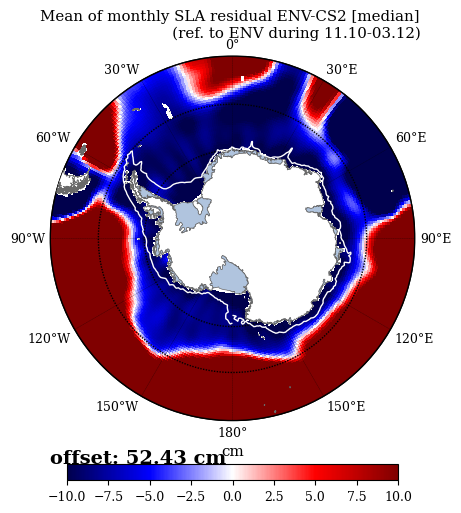

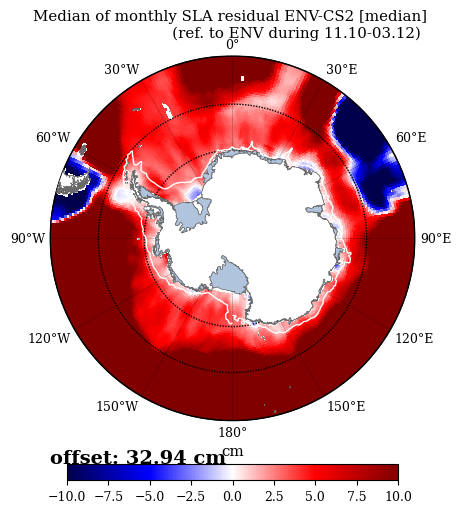

In [2]:
#c3

"""
Compute SLA referenced to the ENV_MDT overlap period.


Last modified: 31 Mar 2021
"""

import numpy as np
from numpy import ma

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.ticker import FormatStrFormatter
import matplotlib

from palettable.colorbrewer.diverging import RdBu_11, PuOr_11

import xarray as xr
import pandas as pd

import sys

#----------------------------------------------------------
# Define directories
voldir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/'
griddir = voldir + 'altimetry_cpom/3_grid_dot/'
lmdir = voldir + 'land_masks/'
figdir = voldir + '../PhD_figures/Figures_v8/'

scriptdir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_scripts/'
auxscriptdir = scriptdir + '/aux_func/'

sys.path.append(auxscriptdir)
from aux_1_filenames import cs2_id_list as filenames
import aux_func as ft


sys.path.append(auxscriptdir)
import aux_func as fc
import aux_stereoplot as st

#----------------------------------------------------------

# Intersatellite offset (median, metres)
#intersat_off = 0.041465 # for SLA (SSH-geoid); filt sigma=2 grid cells
#intersat_off = 0.041638 # filter sigma=1 grid cell
#intersat_off = 0.041194 # for SSHA (SSH-MSS)
# 7, sigma=2
#intersat_off = 0.037405
#7, sigma=3
#intersat_off = 0.037129

# 3 may 2020:
#intersat_off = 0.03712

#----------------------------------------------------------

# # # # # # # # # # # #
geoidtype = '_goco05c'#'_eigen6s4v2_neg' #'_egm2008' #'_goco05c'
statistics = 'median'
# # # # # # # # # # # #

cs2_file = griddir + '2week_dot_cs2_30b' + statistics + geoidtype + '_sig3.nc'
env_file = griddir + '2week_dot_env_30b' + statistics + geoidtype + '_sig3.nc'

with xr.open_dataset(cs2_file) as cs2_dict:
    print(cs2_dict.keys())
with xr.open_dataset(env_file) as env_dict:
    print(env_dict.keys())

# overlap period
time = pd.date_range('2010-11-01', '2012-03-01', freq='1MS')

# overlap period - 2 weeks avg
time_start = pd.date_range('2010-11-01', '2012-03-01', freq='1MS')
time_mid = time_start + timedelta(days=14)
time = time_start.append(time_mid).sort_values()


env = env_dict.sel(time=slice(time[0], time[-1]))
cs2 = cs2_dict.sel(time=slice(time[0], time[-1]))

print(env.keys())
print(cs2.keys())

# LAT/LON GRID
lat = env.latitude.values
lon = env.longitude.values
elat = env.edge_lat.values
elon = env.edge_lon.values

eglat, eglon = np.meshgrid(elat, elon)

lmask = env.land_mask.values

#----------------------------------------------------------
# OVERLAP PERIOD SLA OFFSET
#----------------------------------------------------------
itt = len(time)

cs2_mdt = cs2.dot.mean('time')
env_mdt = env.dot.mean('time')

cs2_sla = cs2.dot - env_mdt
env_sla = env.dot - env_mdt

# # # # # # # # # # # #
# SLA residual - time series of maps
sla_dif = env_sla - cs2_sla

# map of mean/median residual
sla_dif_median = sla_dif.median("time").values
sla_dif_mean = sla_dif.mean("time").values

#----------------------------------------------------------
# area-weighted circumpolar SLA average - time series
#----------------------------------------------------------
area_grid = fc.grid_area(eglon, eglat)
area_grid[lmask==1] = np.nan # mask where land

# mask cells where the offset is negative
res_median = sla_dif_median.copy()
res_mean = sla_dif_mean.copy()

res_median[res_median<0] = np.nan
res_mean[res_mean<0] = np.nan

# area weighted average
a1 = res_mean*area_grid
a2 = res_median*area_grid

area1_sum = np.nansum(area_grid[~np.isnan(a1)])
area2_sum = np.nansum(area_grid[~np.isnan(a2)])

avg_off1 = np.nansum(a1)/area1_sum
avg_off2 = np.nansum(a2)/area2_sum

print("mean area weighted avg: %s (m)" % avg_off1)
print("median area weighted avg: %s (m)" % avg_off2)

#----------------------------------------------------------
#           PLOT of mean/median of RESIDUAL
#----------------------------------------------------------
cbar_range = [-10, 10]
cbar_units = 'cm'
cmap = cm.seismic
both = 'w'
# # # # # # # # # # # #
fig, ax, m = st.spstere_plot(eglon, eglat, sla_dif_mean*1e2,
                cbar_range, cmap, cbar_units, both)
fig.tight_layout(rect=[0, -.1, 1, .95])
fig.suptitle(('{}').format('Mean of monthly SLA residual ENV-CS2 [%s] \n\
                           (ref. to ENV during 11.10-03.12)' % statistics))
ax.annotate('offset: %.2f cm' % (avg_off1*1e2),
    xy=(.1,.1),
    xycoords='figure fraction',
    weight='bold', fontsize=14)


# # # # # # # # # # # #
both = 'w'
fig, ax, m = st.spstere_plot(eglon, eglat, sla_dif_median*1e2,
                cbar_range, cmap, cbar_units, both)
fig.tight_layout(rect=[0, -.1, 1, .95])
fig.suptitle(('{}').format('Median of monthly SLA residual ENV-CS2 [%s] \n\
                           (ref. to ENV during 11.10-03.12)' % statistics))
ax.annotate('offset: %.2f cm' % (avg_off2*1e2),
    xy=(.1,.1),
    xycoords='figure fraction',
    weight='bold', fontsize=14)

sys.exit() # - use if want to stop !!!
# stop here


# # # # # # # # # # # #
# # save in a file
# offset = xr.Dataset({'mean_map' : (('longitude', 'latitude'), sla_dif_mean),
#                     'median_map' : (('longitude', 'latitude'), sla_dif_median),
#                     'mean_aw_avg' : avg_off1,
#                     'median_aw_avg' : avg_off2},
#                     coords={'longitude' : lon,
#                     'latitude' : lat})
# offset.to_netcdf(griddir + 'intersat_off_b' + statistics + '.nc')

# A. correct CS2 SLA with the aw avg of the mean in every cell
# - - - - - - - - - - - - - - - - - - - -
cs2_sla_v = cs2_sla.values + avg_off1
env_sla_v = env_sla.values

# and compare area-weighted averaged time series
env_sla_v[sla_dif_mean<0] = np.nan
cs2_sla_v[sla_dif_mean<0] = np.nan

# - - - - - - - - - - - - - - - - - - - -
# area-weighted avg and residual
avg_sla_cs2, avg_sla_env = [ma.ones((itt, )) for _ in range(2)]
for i in range(itt):
    aa = ma.masked_invalid(cs2_sla_v[:, :, i]*area_grid)
    total_area = ma.sum(area_grid[~aa.mask])
    avg_sla_cs2[i] = ma.sum(aa)/total_area

    bb = ma.masked_invalid(env_sla_v[:, :, i]*area_grid)
    total_area = ma.sum(area_grid[~bb.mask])
    avg_sla_env[i] = ma.sum(bb)/total_area

# difference between satellites; mean and median of time series
overlap_median = ma.median(avg_sla_env - avg_sla_cs2)
overlap_mad = ma.median(abs((avg_sla_env-avg_sla_cs2)-overlap_median))

overlap_mean = ma.mean(avg_sla_env - avg_sla_cs2)
overlap_std = ma.std(avg_sla_env-avg_sla_cs2, ddof=1)

print("Envisat - CS2 offset (cm) ")
print("median: %.4f + %.4f cm" %(overlap_median*1e2,
                                 overlap_mad*1e2))
print("  mean: %.4f + %.4f cm" %(overlap_mean*1e2,
                                 overlap_std*1e2))

#----------------------------------------------------------

plt.ion()
fig, ax =  plt.subplots(figsize=(10, 4))
x = time
ax.plot(x, (avg_sla_cs2)*1e2,
        c='coral', marker='o',
        label='CS2 referenced to ENV')
ax.plot(x, avg_sla_env*1e2, c='k',
        marker='o',
        label='ENV')
ax.plot(x, (avg_sla_env-avg_sla_cs2)*1e2,
        c='grey', ls='--',
        marker='o', markerfacecolor='none',
        label='residual [ENV-CS2 corrected]')
ax.axhline(0, ls=':', c='grey')
ax.legend()
ax.set_ylabel("SLA (cm)")
ax.set_title(r"Mean residual offset and std: (%.3f $\pm$ %.3f) cm"
             % (overlap_mean*1e2, overlap_std*1e2))
plt.tight_layout()

#----------------------------------------------------------
#----------------------------------------------------------
# A. correct CS2 SLA with the aw avg of the median in every cell
# - - - - - - - - - - - - - - - - - - - -
cs2_sla_v = cs2_sla.values + avg_off2
env_sla_v = env_sla.values

# and compare area-weighted averaged time series
env_sla_v[sla_dif_median<0] = np.nan
cs2_sla_v[sla_dif_median<0] = np.nan

# - - - - - - - - - - - - - - - - - - - -
# area-weighted avg and residual
avg_sla_cs2, avg_sla_env = [ma.ones((itt, )) for _ in range(2)]
for i in range(itt):
    aa = ma.masked_invalid(cs2_sla_v[:, :, i]*area_grid)
    total_area = ma.sum(area_grid[~aa.mask])
    avg_sla_cs2[i] = ma.sum(aa)/total_area

    bb = ma.masked_invalid(env_sla_v[:, :, i]*area_grid)
    total_area = ma.sum(area_grid[~bb.mask])
    avg_sla_env[i] = ma.sum(bb)/total_area

# difference between satellites; mean and median of time series
overlap_median = ma.median(avg_sla_env - avg_sla_cs2)
overlap_mad = ma.median(abs((avg_sla_env-avg_sla_cs2)-overlap_median))

overlap_mean = ma.mean(avg_sla_env - avg_sla_cs2)
overlap_std = ma.std(avg_sla_env-avg_sla_cs2, ddof=1)

print("Envisat - CS2 offset (cm) ")
print("median: %.4f + %.4f cm" %(overlap_median*1e2,
                                 overlap_mad*1e2))
print("  mean: %.4f + %.4f cm" %(overlap_mean*1e2,
                                 overlap_std*1e2))

#----------------------------------------------------------

plt.ion()
fig, ax =  plt.subplots(figsize=(10, 4))
x = time
ax.plot(x, (avg_sla_cs2)*1e2,
        c='coral', marker='o',
        label='CS2 referenced to ENV')
ax.plot(x, avg_sla_env*1e2, c='k',
        marker='o',
        label='ENV')
ax.plot(x, (avg_sla_env-avg_sla_cs2)*1e2,
        c='grey', ls='--',
        marker='o', markerfacecolor='none',
        label='residual [ENV-CS2 corrected]')
ax.axhline(0, ls=':', c='grey')
ax.legend()
ax.set_ylabel("SLA (cm)")
ax.set_title(r"Median residual offset and mad: (%.3f $\pm$ %.3f) cm"
             % (overlap_median*1e2, overlap_mad*1e2))
plt.tight_layout()

#----------------------------------------------------------
#
# # save a mask with 1s where the offset > 0 and 0 everywhere else
# dif_mask = ma.ones((msla_dif.shape))
# dif_mask[msla_dif.mask==True] = ma.masked
# dif_mask[msla_dif<0]=0
#
# lo, la = dif_mask.shape
# elo, ela = len(elon), len(elat)





